In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
# from tensorboardX import SummaryWriter

use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 64
np.random.seed(42)
torch.manual_seed(42)


## Dataloaders
train_dataset = datasets.MNIST('mnist_data/', train=True, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))
test_dataset = datasets.MNIST('mnist_data/', train=False, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

## Simple NN. You can change this if you want. If you change it, mention the architectural details in your report.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.f1 = nn.Linear(28*28, 50)
        self.f2 = nn.Linear(50, 50)
        self.f3 = nn.Linear(50, 50)
        self.out = nn.Linear(50, 10)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.f1(x))
        x = F.relu(self.f2(x))
        x = F.relu(self.f3(x))
        x = self.out(x)
        return x

class Normalize(nn.Module):
    def forward(self, x):
        return (x - 0.1307)/0.3081

# Add the data normalization as a first "layer" to the network
# this allows us to search for adverserial examples to the real image, rather than
# to the normalized image
model = nn.Sequential(Normalize(), Net())

model = model.to(device)
model.train()

Sequential(
  (0): Normalize()
  (1): Net(
    (f1): Linear(in_features=784, out_features=50, bias=True)
    (f2): Linear(in_features=50, out_features=50, bias=True)
    (f3): Linear(in_features=50, out_features=50, bias=True)
    (out): Linear(in_features=50, out_features=10, bias=True)
  )
)

# Problem 2

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
# from tensorboardX import SummaryWriter

use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 64
np.random.seed(42)
torch.manual_seed(42)


## Dataloaders
train_dataset = datasets.MNIST('mnist_data/', train=True, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))
test_dataset = datasets.MNIST('mnist_data/', train=False, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

## Simple NN. You can change this if you want. If you change it, mention the architectural details in your report.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.f1 = nn.Linear(28*28, 50)
        self.f2 = nn.Linear(50, 50)
        self.f3 = nn.Linear(50, 50)
        self.out = nn.Linear(50, 10)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.f1(x))
        x = F.relu(self.f2(x))
        x = F.relu(self.f3(x))
        x = self.out(x)
        return x

class Normalize(nn.Module):
    def forward(self, x):
        return (x - 0.1307)/0.3081

# Add the data normalization as a first "layer" to the network
# this allows us to search for adverserial examples to the real image, rather than
# to the normalized image
model = nn.Sequential(Normalize(), Net())

model = model.to(device)
model.train()

In [17]:
def train_model(model, num_epochs, learning_rate=0.1, momentum=0.95):
    entropy_loss = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    
    for _ in range(num_epochs):
        model.train() 
        for (data, target) in train_loader:
            data = data.to(device)
            target = target.to(device)
            
            optimizer.zero_grad()           
            outputs = model(data)           
            loss = entropy_loss(outputs, target)
            loss.backward()                 
            optimizer.step()                

In [18]:
train_model(model, 20)
torch.save(model.state_dict(), 'weights.pt')

In [11]:
model = nn.Sequential(Normalize(), Net())

state_dict = torch.load('weights.pt')
model.load_state_dict(state_dict)

/var/folders/1n/w6t2b14d7sscxykjcvh220680000gn/T/ipykernel_96147/3283495263.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('weights.pt')


<All keys matched successfully>

In [19]:
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad(): 
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            outputs = model(data) 
            _, predicted = torch.max(outputs, 1) 
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100.0 * correct / total
    print(f'Model Accuracy on MNIST Test Set: {accuracy:.2f}%')
    return accuracy

accuracy = evaluate_model(model, test_loader, device)

Model Accuracy on MNIST Test Set: 11.35%


In [29]:
def interval_analysis(model, x, eps):
    f1_weight = model[1].f1.weight.data 
    f1_bias = model[1].f1.bias.data   
    
    f2_weight = model[1].f2.weight.data
    f2_bias = model[1].f2.bias.data  
    
    f3_weight = model[1].f3.weight.data 
    f3_bias = model[1].f3.bias.data 
    
    out_weight = model[1].out.weight.data 
    out_bias = model[1].out.bias.data 
    
    x_lower = x.view(-1) - eps
    x_upper = x.view(-1) + eps

    f1_lower = torch.zeros(50)
    f1_upper = torch.zeros(50)
    
    for i in range(f1_weight.size(0)):
        sum_lower = 0.0
        sum_upper = 0.0
        for j in range(f1_weight.size(1)): 
            w = f1_weight[i][j].item()
            if w >=0:
                sum_lower += w * x_lower[j]
                sum_upper += w * x_upper[j]
            else:
                sum_lower += w * x_upper[j]
                sum_upper += w * x_lower[j]
        f1_lower[i] = sum_lower + f1_bias[i]
        f1_upper[i] = sum_upper + f1_bias[i]

    f1_lower = torch.clamp(f1_lower, min=0.0)
    f1_upper = torch.clamp(f1_upper, min=0.0)

    f2_lower = torch.zeros(50)
    f2_upper = torch.zeros(50)
    
    for i in range(f2_weight.size(0)):
        sum_lower = 0.0
        sum_upper = 0.0
        for j in range(f2_weight.size(1)):
            w = f2_weight[i][j].item()
            if w >=0:
                sum_lower += w * f1_lower[j]
                sum_upper += w * f1_upper[j]
            else:
                sum_lower += w * f1_upper[j]
                sum_upper += w * f1_lower[j]
        f2_lower[i] = sum_lower + f2_bias[i]
        f2_upper[i] = sum_upper + f2_bias[i]

    f2_lower = torch.clamp(f2_lower, min=0.0)
    f2_upper = torch.clamp(f2_upper, min=0.0)

    f3_lower = torch.zeros(50)
    f3_upper = torch.zeros(50)
    
    for i in range(f3_weight.size(0)):
        sum_lower = 0.0
        sum_upper = 0.0
        for j in range(f3_weight.size(1)):
            w = f3_weight[i][j].item()
            if w >=0:
                sum_lower += w * f2_lower[j]
                sum_upper += w * f2_upper[j]
            else:
                sum_lower += w * f2_upper[j]
                sum_upper += w * f2_lower[j]
        f3_lower[i] = sum_lower + f3_bias[i]
        f3_upper[i] = sum_upper + f3_bias[i]
    
    f3_lower = torch.clamp(f3_lower, min=0.0)
    f3_upper = torch.clamp(f3_upper, min=0.0)

    out_lower = torch.zeros(10)
    out_upper = torch.zeros(10)
    
    for i in range(out_weight.size(0)):
        sum_lower = 0.0
        sum_upper = 0.0
        for j in range(out_weight.size(1)):
            w = out_weight[i][j].item()
            if w >=0:
                sum_lower += w * f3_lower[j]
                sum_upper += w * f3_upper[j]
            else:
                sum_lower += w * f3_upper[j]
                sum_upper += w * f3_lower[j]
        out_lower[i] = sum_lower + out_bias[i]
        out_upper[i] = sum_upper + out_bias[i]
    return out_lower, out_upper


In [32]:

!pip install tqdm
from tqdm import tqdm
eps = [0.01 * i for i in range(1, 11)]
robust_rates = []

for e in eps:
    robust_count = 0
    process_count = 0
    test_num = 100
    print("eps: ", e)
    for idx, (data, target) in enumerate(tqdm(test_loader)):
        process_count += 1
        data = data.to(device)
        target = target.item()
        

        f_l, f_u = interval_analysis(model, data, e)
        c_l = f_l[target]

        incorrect_u = f_u
        incorrect_u[target] = -1000

        max_incorrect_u = torch.max(incorrect_u)
        
        if c_l > max_incorrect_u:
            robust_count +=1
        if process_count >= test_num:
            break
    robust_rate = robust_count / test_num
    print("robust_rate: ", robust_rate)


Defaulting to user installation because normal site-packages is not writeable
eps:  0.01


  1%|          | 99/10000 [00:57<1:35:06,  1.74it/s]


robust_rate:  0.14
eps:  0.02


  1%|          | 99/10000 [00:56<1:33:43,  1.76it/s]


robust_rate:  0.14
eps:  0.03


  1%|          | 99/10000 [00:55<1:31:54,  1.80it/s]


robust_rate:  0.14
eps:  0.04


  1%|          | 99/10000 [00:54<1:30:23,  1.83it/s]


robust_rate:  0.13
eps:  0.05


  1%|          | 99/10000 [00:55<1:32:24,  1.79it/s]


robust_rate:  0.12
eps:  0.06


  1%|          | 99/10000 [01:30<2:31:07,  1.09it/s] 


robust_rate:  0.11
eps:  0.07


  1%|          | 99/10000 [01:02<1:44:48,  1.57it/s]


robust_rate:  0.09
eps:  0.08


  1%|          | 99/10000 [01:00<1:40:57,  1.63it/s]


robust_rate:  0.05
eps:  0.09


  1%|          | 99/10000 [00:56<1:33:28,  1.77it/s]


robust_rate:  0.04
eps:  0.1


  1%|          | 99/10000 [00:57<1:35:09,  1.73it/s]

robust_rate:  0.04


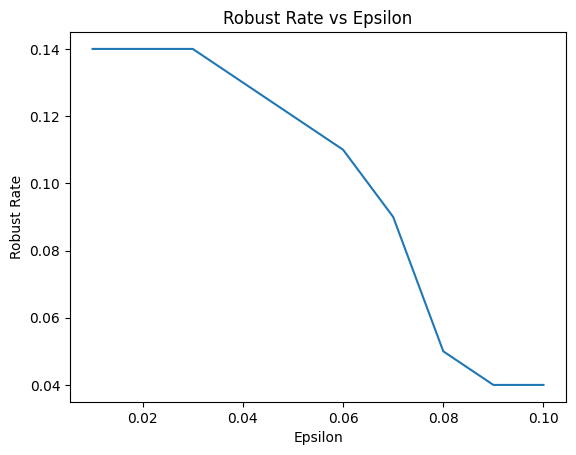

In [33]:
import matplotlib.pyplot as plt

eps = [0.01 * i for i in range(1, 11)]
robust_rates = [0.14, 0.14, 0.14, 0.13, 0.12, 0.11, 0.09, 0.05, 0.04, 0.04]
plt.plot(eps, robust_rates)
plt.xlabel('Epsilon')
plt.ylabel('Robust Rate')
plt.title('Robust Rate vs Epsilon')
plt.show()